# GTEx v8 RNA-seq data processing for eQTLs : Exploratory analysis

This notebook outlines how the expression matrices are handled prior to the eQTL mapping, and also include some exploratory analysis on the data. In particular, we focus on hidden structures within the expression data, and how we correct for the relevant covariates, both known and inferred.

On Della, the RNA-seq project directory is located at:

<code>/tigress/BEE/RNAseq/</code>

In [12]:
import os
proj = os.environ['proj']

## Creating reference tables - samples, subjects and tissues

I wrote a script that reads in the GTEx sample and subject-level annotation files, downloaded from dbGaP and located at:

<code>/tigress/BEE/gtex/dbGaP-7716/57610/gtex/exchange/GTEx_phs000424/exchange/analysis_releases/GTEx_Analysis_2017-06-05_v8/sample_annotations/</code>

and writing three tables that are organized at sample, subject and tissue levels:

<code>/tigress/BEE/RNAseq/Data/Resources/gtex/tables/v8/</code>

The code can be found at:

<code>https://github.com/bee-hive/RNAseq_pipeline/blob/master/Scripts/misc/silver/v8_organize_tissues_reference_tables.R</code>

<b>Note: The naming convention of these two tissues have been altered, in accordance to the GTEx v8 analysis naming convention:

Brain_Spinal_cord_cervical_c1 - Brain_Spinal_cord_cervical_c-1

Cells_EBVtransformed_lymphocytes - Cells_EBV-transformed_lymphocytes</b>

In [ ]:
%%bash

Rscript $proj/Scripts/misc/silver/v8_organize_tissues_reference_tables.R

In [ ]:
%%bash

echo 'Sample table'
head -n 10 $proj/Data/Resources/gtex/tables/v8/sample_table.txt
echo ' '
echo 'Subject table'
head -n 10 $proj/Data/Resources/gtex/tables/v8/subject_table.txt
echo ' '
echo 'Tissue table'
head -n 10 $proj/Data/Resources/gtex/tables/v8/tissue_table.txt
echo ' '
echo 'Number of samples + 1'
wc -l $proj/Data/Resources/gtex/tables/v8/sample_table.txt
echo ' '
echo 'Number of subjects + 1'
wc -l $proj/Data/Resources/gtex/tables/v8/subject_table.txt
echo ' '
echo 'Number of tissues + 1'
wc -l $proj/Data/Resources/gtex/tables/v8/tissue_table.txt

<code>
Sample table

SAMPID	SMTSD	SUBJID	SEX	RACE	AGE	BMI	tissue_name
GTEX-1117F-0226-SM-5GZZ7	Adipose - Subcutaneous	GTEX-1117F	2	2	66	32.12	Adipose_Subcutaneous
GTEX-1117F-0426-SM-5EGHI	Muscle - Skeletal	GTEX-1117F	2	2	66	32.12	Muscle_Skeletal
GTEX-1117F-0526-SM-5EGHJ	Artery - Tibial	GTEX-1117F	2	2	66	32.12	Artery_Tibial
GTEX-1117F-0626-SM-5N9CS	Artery - Coronary	GTEX-1117F	2	2	66	32.12	Artery_Coronary
GTEX-1117F-0726-SM-5GIEN	Heart - Atrial Appendage	GTEX-1117F	2	2	66	32.12	Heart_Atrial_Appendage
GTEX-1117F-1326-SM-5EGHH	Adipose - Visceral (Omentum)	GTEX-1117F	2	2	66	32.12	Adipose_Visceral_Omentum
GTEX-1117F-2226-SM-5N9CH	Ovary	GTEX-1117F	2	2	66	32.12	Ovary
GTEX-1117F-2426-SM-5EGGH	Uterus	GTEX-1117F	2	2	66	32.12	Uterus
GTEX-1117F-2526-SM-5GZY6	Vagina	GTEX-1117F	2	2	66	32.12	Vagina

Subject table
SUBJID	SEX	AGE	RACE	ETHNCTY	BMI	num_samples
GTEX-1117F	2	66	2	0	32.12	13
GTEX-111CU	1	57	3	0	33.57	19
GTEX-111FC	1	61	3	0	25.06	16
GTEX-111VG	1	63	3	0	29.53	11
GTEX-111YS	1	62	3	0	30.78	25
GTEX-1122O	2	64	3	0	32.76	26
GTEX-1128S	2	66	3	0	25.82	15
GTEX-113IC	1	66	2	0	26.96	6
GTEX-113JC	2	53	3	0	27.99	11
 
Tissue table
tissue_name	SMTS	SMUBRTRM	num_samples
Muscle_Skeletal	Muscle	gastrocnemius medialis	803
Whole_Blood	Blood	venous blood	755
Skin_Sun_Exposed_Lower_leg	Skin	lower leg skin	701
Adipose_Subcutaneous	Adipose Tissue	subcutaneous adipose tissue	663
Artery_Tibial	Blood Vessel	tibial artery	663
Thyroid	Thyroid	thyroid gland	653
Nerve_Tibial	Nerve	tibial nerve	620
Skin_Not_Sun_Exposed_Suprapubic	Skin	suprapubic skin	605
Lung	Lung	upper lobe of left lung	578
 
Number of samples + 1
   18221 /tigress/BEE/RNAseq/Data/Resources/gtex/tables/v8/sample_table.txt
 
Number of subjects + 1
     949 /tigress/BEE/RNAseq/Data/Resources/gtex/tables/v8/subject_table.txt
 
Number of tissues + 1
      55 /tigress/BEE/RNAseq/Data/Resources/gtex/tables/v8/tissue_table.txt
</code>

There are <b>18220</b> samples coming from <b>948</b> subjects, over <b>54</b> tissues - certainly an extensive RNA-seq dataset by today's standards.

## Organizing the GTEx gct expression matrices and normalizing them

<code>Note: This part of the notebook is obsolete - we simply take the normalized version of the expression provided by the GTEx consortium.</code>

The GTEx v8 expression gct files are also downloaded from dbGaP and are located at:

<code>/tigress/BEE/gtex/dbGaP-7716/57610/gtex/exchange/GTEx_phs000424/exchange/analysis_releases/GTEx_Analysis_2017-06-05_v8/rna_seq</code>

We obtain the main gct files, and separate out by tissues first, for four sets of expression matrices that have been obtained using [RSEMv1.3.0](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-12-323):

- Gene TPM
- Gene Counts
- Transcript TPM
- Transcript Counts

The script for doing this is located at:

<code>https://github.com/bee-hive/RNAseq_pipeline/blob/master/Scripts/misc/silver/v8_separate_expression_matrices.py</code>

The wrapper script for the cluster:

<code>https://github.com/bee-hive/RNAseq_pipeline/blob/master/Scripts/misc/silver/v8_separate_expression_matrices_wrapper.py</code>

In [ ]:
%%bash

python $proj/Scripts/misc/silver/v8_separate_expression_matrices_wrapper.py

As a result of running this, the separated expression matrices are deposited at:

<code>/tigress/BEE/gtex/data/phenotype/expression/expression_matrices/v8/</code>

I've organized the directory such that there are 5 subdirectories:

- dbGaP - Copy of the original files downloaded from dbGaP
- gene_list - List of Genes that are used for downstream analysis, after filtering
- log_transform - Log-transformed version of the count matrices
- quantile_norm - Quantile-normalized version of the TPM matrices
- raw - Tissue-separated version of the dbGaP gct files

The dbGaP gene matrices have <b>58219</b> genes, and the transcript matrices have <b>199324</b> transcripts.

The next step is normalization. The normalization script does the following:

- Filter gene and transcript tables based on minimal gene expression - our threshold is at least 0.1 TPM for at least 10 individuals. This criteria only applies to genes, and in the transcript table, all transcripts that belong to the filtered gene list are included.
- Quantile-normalize the TPM matrices. There are two types of QN procedure:

<code>QN the entire expression profile (all samples, all genes, ties broken by averaging), and then QN for each gene (ties broken randomly)</code>

<code>QN for each sample (ties broken by averaging), and then QN for each gene (ties broken randomly)</code>

- Log-transform the Count matrices (Log2 transform the TPM values + 1, which maps 0 to 0 and 1 to 1)

The script for doing this is located at:

<code>https://github.com/bee-hive/RNAseq_pipeline/blob/master/Scripts/processing/silver/v8_normalize_matrices.py</code>

The wrapper script for the cluster:

<code>https://github.com/bee-hive/RNAseq_pipeline/blob/master/Scripts/processing/silver/v8_normalize_matrices_wrapper.py</code>

In [ ]:
%%bash

python $proj/Scripts/processing/silver/v8_normalize_matrices_wrapper.py

It is worth noting that in order to bring up the list of transcripts that belong to a gene, I used [GENCODE v.26](https://www.gencodegenes.org/releases/26lift37.html). The converted Python OrderedDict is saved at:

<code>/tigress/BEE/RNAseq/Data/Resources/annotations/silver/gencode.v26.transcripts</code>

- The resulting quantile-normalized TPM matrices are saved under the <code>quantile_norm</code> subdirectory, with the postfix <code>profile_norm.txt</code> meaning the first QN method, and <code>sample_norm.txt</code> meaning the second.
- The resulting log-transformed Count matrices are saved under the <code>log_transform</code> subdirectory.
- The filtered gene list and transcript list are saved under the <code>gene_list</code> subdirectory.


## Looking at an example expression matrix

Let's look at example expression matrices - starting with Whole Blood

In [ ]:
# Rscript

log_gene_tissue = read.table('v8_RSEMv1.3.0_gene_count_Whole_Blood.txt', header=T, stringsAsFactors=F, sep='\t')
tpm_gene_tissue = read.table('v8_RSEMv1.3.0_gene_tpm_Whole_Blood.txt', header=T, stringsAsFactors=F, sep='\t')

rownames(log_gene_tissue) = log_gene_tissue$X
log_gene_tissue = log_gene_tissue[,c(2:ncol(log_gene_tissue))]

head(rowMeans(tpm_gene_tissue)[order(-rowMeans(tpm_gene_tissue))], 10)
#  ENSG00000244734.3 ENSG00000188536.12  ENSG00000206172.8 
#           17.68628           17.60776           16.76925 
# ENSG00000163220.10 ENSG00000087086.14 ENSG00000167996.15 
#           13.48865           12.21512           12.18122 
# ENSG00000166710.17 ENSG00000185201.16 ENSG00000234745.10 
#           12.09877           11.95525           11.80426 
# ENSG00000205542.10 
#           11.64428 

head(rowMeans(log_gene_tissue)[order(-rowMeans(log_gene_tissue))], 10)
#  ENSG00000244734.3 ENSG00000188536.12  ENSG00000206172.8 
#           22.11958           21.97939           21.04356 
# ENSG00000163220.10 ENSG00000075624.13 ENSG00000087086.14 
#           17.76252           17.35858           17.32947 
# ENSG00000234745.10 ENSG00000167996.15 ENSG00000119535.17 
#           17.28139           17.21137           17.05182 
# ENSG00000166710.17 
#           16.76941 

globin_genes = c('ENSG00000244734.3', 'ENSG00000188536.12', 'ENSG00000206172.8')

log_gene_tissue = log_gene_tissue[setdiff(rownames(log_gene_tissue), globin_genes),]
tpm_gene_tissue = tpm_gene_tissue[setdiff(rownames(tpm_gene_tissue), globin_genes),]

library(ggplot2)

# Plot mean histograms

qplot(rowMeans(log_gene_tissue), geom='histogram', bins = 50) + xlab('Mean of log gene counts')
qplot(rowMeans(tpm_gene_tissue), geom='histogram', bins = 50) + xlab('Mean of log gene TPM')

The first three genes (ENSG00000244734.3, ENSG00000188536.12, ENSG00000206172.8) are globin genes - they were note depleted in the preparation of whole blood samples. For our exploration, we'll remove these genes for now.

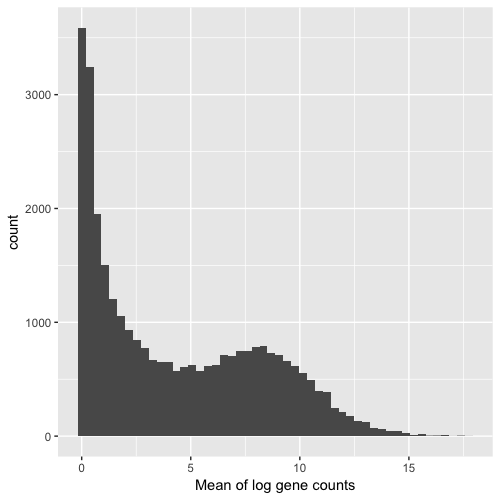

In [14]:
from IPython.display import Image
Image(filename = proj + '/Analysis/auxiliary/expression/v8/wholeblood_log_counts_hist.png') 

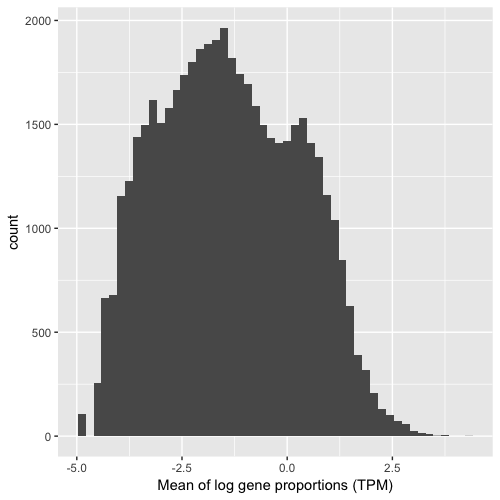

In [17]:
Image(filename = proj + '/Analysis/auxiliary/expression/v8/wholeblood_log_tpm_hist.png') 

The difference comes from comparing mean log counts and proportions (tpm), but still we are able to observe a mixture of at least two distributions. In the case of counts, a roughly normal distribution and a Poisson (or Gamma) distribution with a lot of values close to 0. In the case of porportions (TPM), a two roughly normal distributions. (But it seems like there could be additional ones)

How about the inherent variation among the expression values?

In [ ]:
# Rscript

library(MatrixStats)

# 1st plot
qplot(log10(rowVars(as.matrix(tpm_gene_tissue))), geom='histogram', bins = 50) + xlab('Variance of log gene proportions (TPM)')

# Mean deviation from means in terms of sigmas?
means = rowMeans(tpm_gene_tissue)
tpm_mean_center = tpm_gene_tissue - means
tpm_deviations = tpm_mean_center / rowSds(as.matrix(tpm_mean_center))

# 2nd plot
qplot(log10(unlist(tpm_deviations[sample(c(1:nrow(tpm_deviations)), 1000),])), geom='histogram', bins = 50) + xlab('Deviation from mean (in sigmas) for 1000 genes')

means = rowMeans(log_gene_tissue)
log_mean_center = log_gene_tissue - means
log_deviations = log_mean_center / rowSds(as.matrix(log_mean_center))

# 3rd plot
qplot(unlist(log_deviations[sample(c(1:nrow(log_deviations)), 1000),]), geom='histogram', bins = 50) + xlab('Deviation from mean (in sigmas) for 1000 genes')

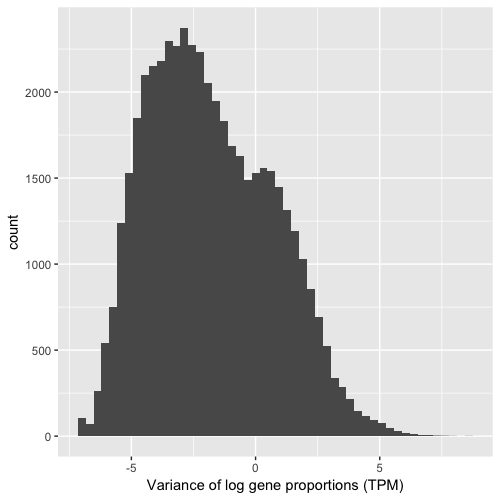

In [19]:
Image(filename = proj + '/Analysis/auxiliary/expression/v8/wholeblood_log_tpm_var_hist.png')

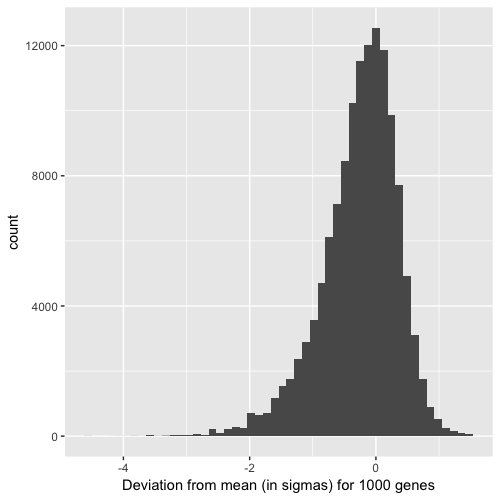

In [23]:
Image(filename = proj + '/Analysis/auxiliary/expression/v8/wholeblood_log_deviation_tpm.png')

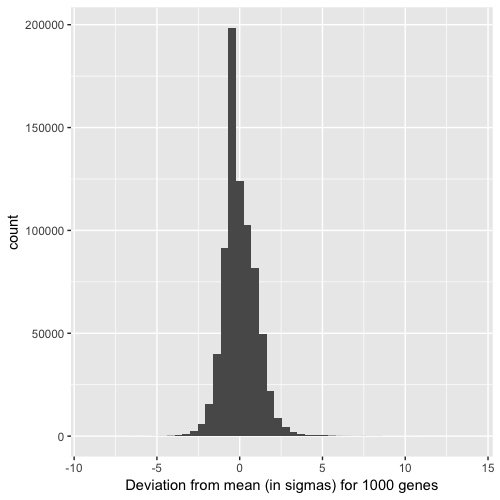

In [22]:
Image(filename = proj + '/Analysis/auxiliary/expression/v8/wholeblood_deviation_log.png')

For both log deviation of TPMs (2nd plot) and deviation of log counts (3rd plot), we see a distribution centered roughly around 0, although it is tough to say that we see a normal distribution. However, it should be noted that these plots are showing the histogram for 1000 randomly sampled genes in each matrix. Especially in the case of TPMs, quantile normalization makes sure that the distribution is forced into a nice Gaussian, since there tend to be a lot of outliers that can skew (and potentially inflate) the test statistics that we calculate.

Now, let's compare the quantile-normalized expression matrix and the log count matrix:

In [ ]:
# Rscript

# Comparing normalized matrix and log count matrix
header = readLines(gzfile('Whole_Blood.v8.normalized_expression.bed.gz'), n = 1)
header = strsplit(header, '\t')[[1]]
normalized_expression = read.csv(gzfile('Whole_Blood.v8.normalized_expression.bed.gz', 'r'), sep = '\t', stringsAsFactors = FALSE)

colnames(normalized_expression) = header
rownames(normalized_expression) = normalized_expression$gene_id

normalized_expression = normalized_expression[,c(5:ncol(normalized_expression))]
normalized_expression = normalized_expression[setdiff(rownames(normalized_expression), globin_genes),]

colnames(log_deviations) = sapply(colnames(log_deviations), function(x) {paste0(strsplit(x, '\\.')[[1]][1], '-', strsplit(x, '\\.')[[1]][2])})
log_deviations_comparison = log_deviations[rownames(normalized_expression),colnames(normalized_expression)]

inds = sample(c(1:nrow(log_deviations_comparison)), 1000)
qplot(unlist(log_deviations_comparison[inds,]), unlist(normalized_expression[inds,])) + xlab('Deviation from mean (in sigmas) for 1000 genes') + ylab('Quantile-normalized expression')


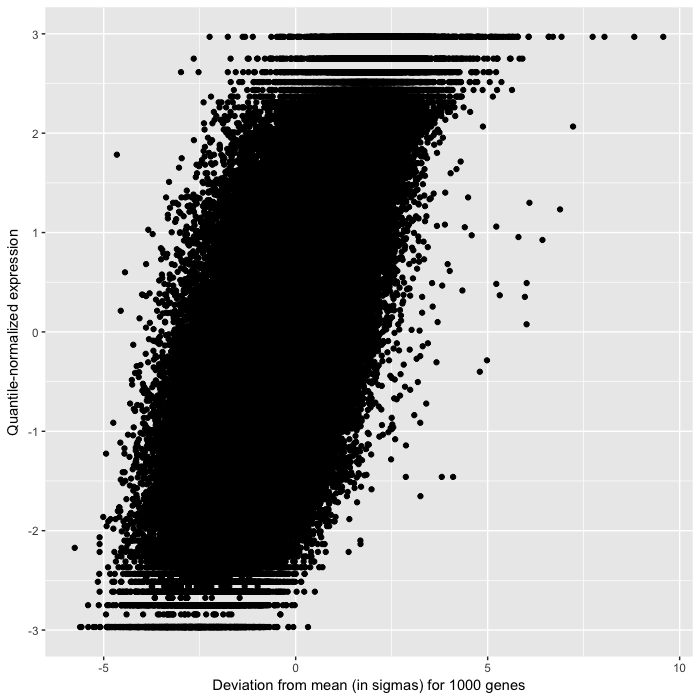

In [24]:
Image(filename = proj + '/Analysis/auxiliary/expression/v8/log_count_QN_comparison.png')

QN expression is much easier to work with, with no values exceeding [-3, 3] and all distributions in a nice Gaussian (0,1). In addition, the log-transformed count matrices may preserve the original expression distribution, but they are not normalized across samples, so the total number of reads is a factor that hasn't been considered. Now, let's compare the QN expression to the TPM matrix, which actually does normalize across the sample by converting expression amount to proportions.

In [ ]:
# Rscript

# Comparing normalized matrix and TPM matrix
log_tpm_gene = log2(tpm_gene_tissue + 1)
log_tpm_mean_center = log_tpm_gene - rowMeans(log_tpm_gene)
colnames(log_tpm_mean_center) = sapply(colnames(log_tpm_mean_center), function(x) {paste0(strsplit(x, '\\.')[[1]][1], '-', strsplit(x, '\\.')[[1]][2])})
log_tpm_mean_center = log_tpm_mean_center[rownames(normalized_expression),colnames(normalized_expression)]
log_tpm_deviations = log_tpm_mean_center / rowSds(as.matrix(log_tpm_mean_center))

inds = sample(c(1:nrow(log_tpm_deviations)), 1000)
qplot(unlist(log_tpm_deviations[inds,]), unlist(normalized_expression[inds,])) + xlab('Deviation from mean (in sigmas) for 1000 genes') + ylab('Quantile-normalized expression')

inds = !is.na(unlist(log_tpm_deviations))
cor(unlist(log_tpm_deviations)[inds], unlist(normalized_expression)[inds], method='spearman')
# [1] 0.644712

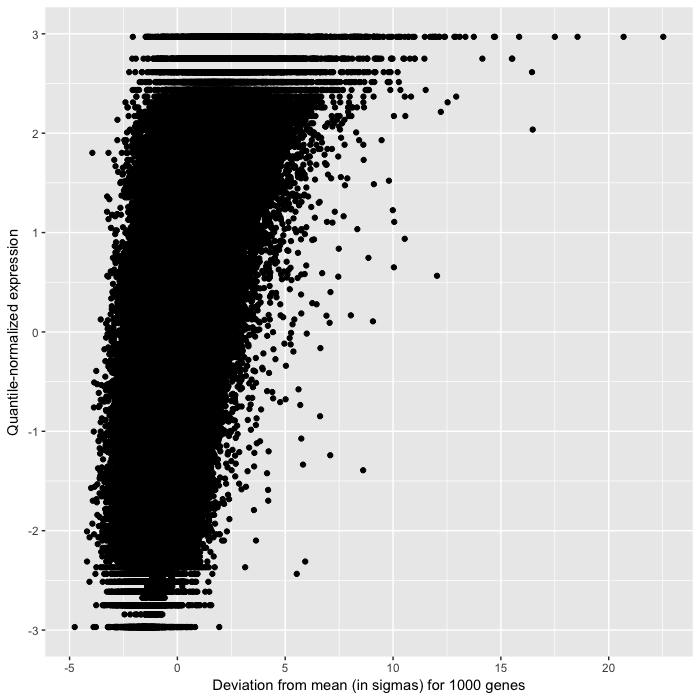

In [26]:
Image(filename = proj + '/Analysis/auxiliary/expression/v8/log_tpm_QN_comparison.png')

It can be seen that relative deviations of log2-transformed TPM tends to be higher. However, the original gene distributions would be more preserved if we were to use the log-transformed TPM matrices. The correlation between these two matrices are just 0.6447, which is a bit surprising.

## Exploring various normalization techniques for expression matrices

Now that we have the expression values in the quantile-normalized form, we can try out various factor analysis techniques that seek to find and correct for unknown factors in the expression profile, which will (hopefully) also include contributions from genotype PCs (roughly accounting for population structure) and other known covariates (other potential confounders).

I will try out the following three methods:

- [SFAMix - Sparse and Dense Factor Analysis](https://arxiv.org/abs/1310.4792) - the code can be downloaded at https://github.com/chuangao/SFAmix
- [PEER - Probabilistic Estimation of Expression Residuals](https://www.ncbi.nlm.nih.gov/pubmed/22343431) - the code can be downloaded at https://github.com/PMBio/peer
- [SVA - Surrogate Variable Analysis](http://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.0030161) - The code is in the form of an [R package](https://www.bioconductor.org/packages/devel/bioc/vignettes/sva/inst/doc/sva.pdf)


### SFAmix - output steps in increments of 50 until convergence (or 5000 steps, whichever comes first)

In [ ]:
%%bash

python $proj/Scripts/processing/covariates_exploratory/v8_sfamix_incremental_wrapper.py

The script for doing this is located at:

<code>https://github.com/bee-hive/RNAseq_pipeline/blob/master/Scripts/processing/covariates_exploratory/v8_sfamix_incremental.R</code>

The wrapper script for the cluster:

<code>https://github.com/bee-hive/RNAseq_pipeline/blob/master/Scripts/processing/covariates_exploratory/v8_sfamix_incremental_wrapper.py</code>

The outputs of this step can be found at:
<code>
/tigress/BEE/RNAseq/Output/processing/exploratory/v8/sfamix/GTEx_Analysis_v8/
</code>

### PEER - looking at the amount of variation explained by the covariates, in PEER increments of 5

The following script calculates the amount of variation in the expression data explained by the known covariates and PEER factors, in increments of five, and saves it to a data frame.

In [ ]:
# Rscript

# center with 'colMeans()'
center_colmeans = function(x) {
    xcenter = colMeans(x)
    x - rep(xcenter, rep.int(nrow(x), ncol(x)))
}

gtex_v8_dir = '/tigress/BEE/RNAseq/Data/Expression/gtex/hg38/GTEx_Analysis_v8_eQTL_expression_matrices/'
f = list.files(gtex_v8_dir, pattern = '.v8.normalized_expression.bed.gz.tbi')
tis_list = as.character(sapply(f, function(x) {strsplit(x, '\\.')[[1]][1]}))
save_file = '/home/bj5/temp.RData'

if (file.exists(save_file)) {
	load(save_file)
} else {
	total_df = data.frame(tissue = character(), n_PEER = numeric(), var_exp = numeric())
	finished_tissues = c()
}

tis_list = setdiff(tis_list, finished_tissues)
for (tissue in tis_list) {
	print(tissue)
	expr_file = paste0(gtex_v8_dir, tissue, '.v8.normalized_expression.bed.gz')
	cov_file = paste0(gtex_v8_dir, 'GTEx_Analysis_v8_eQTL_covariates/', tissue, '.v8.covariates.txt')

	header = readLines(gzfile(expr_file), n = 1)
	header = strsplit(header, '\t')[[1]]
	normalized_expression = read.csv(gzfile(expr_file, 'r'), sep = '\t', stringsAsFactors = FALSE)
	colnames(normalized_expression) = header
	rownames(normalized_expression) = normalized_expression$gene_id
	normalized_expression = normalized_expression[,c(5:ncol(normalized_expression))]

	covs = read.table(cov_file, sep = '\t', stringsAsFactors = FALSE, header = TRUE)
	rownames(covs) = covs$ID
	covs = covs[,c(2:ncol(covs))]
	colnames(covs) = sapply(colnames(covs), function(x) {paste0(strsplit(x, '\\.')[[1]][1], '-', strsplit(x, '\\.')[[1]][2])})

	orig_cov_set = covs[sapply(rownames(covs), function(x) {length(grep("InferredCov", x)) == 0}),]
	PEER_mat = covs[setdiff(rownames(covs), rownames(orig_cov_set)),]
	n_PEER = nrow(covs) - nrow(orig_cov_set)
	for (i in 5*c(0:(n_PEER/5))) {
		print(i)
		cov_set = rbind(orig_cov_set, PEER_mat[c(0:i),])
		# Calculate variance explained
		x = as.matrix(t(cov_set))
		x = center_colmeans(x)
		y = as.matrix(t(normalized_expression))
		beta_x = x %*% solve(t(x) %*% x) %*% t(x) %*% y
		var_exp = sum(beta_x * beta_x)/sum(y * y)
		print(var_exp)
		total_df = rbind(total_df, data.frame(tissue, i, var_exp))
	}
	finished_tissues = c(finished_tissues, tissue)
	save(total_df, finished_tissues, file = save_file)
}